# train

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(10)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [28]:
d = 2
k = 3
*rkeys, rkey = random.split(rkey, 4)

# means = random.uniform(rkeys[0], shape=(k, d))
# covs = random.uniform(rkeys[1], shape=(k, d, d))
# covs = np.einsum("kil,kjl->kij", covs, covs) * 2
# weights = random.dirichlet(rkey[2], alpha=np.ones(k)+1, shape=(k,))
# dist = metrics.GaussianMixture(means, covs, weights)

mean = np.array([1, 2])
cov = np.array([[1,1], [1, 2]])
dist = metrics.Gaussian(mean, cov)

n = 100
assert d == dist.d

n_steps = 1000
svgd = SVGD(dist, n_steps, particle_shape=(n, d))

h = [10000] * d
lr = 0.1
svgd_stepsize = 0.1
bandwidth = h
ksd_bandwidth = 1

In [29]:
rkey = random.split(rkey)[0]

In [30]:
st = time.time()
x0 = svgd.initialize(rkey)
xs, logs = svgd.svgd(x0, svgd_stepsize, h, n_steps)
end = time.time()
print(f"took {end - st} seconds")

st = time.time()
x, log, losses = svgd.train(rkey, h, lr, svgd_stepsize, n_steps, ksd_bandwidth, update_after=0)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")
print("learned bandwidth", log["desc"]["bandwidth"][-3:])

learned_h = log["desc"]["bandwidth"][-1]
st = time.time()
x0 = svgd.initialize(rkey)
xpost, logpost = svgd.svgd(x0, svgd_stepsize, learned_h, n_steps)
end = time.time()
# print(f"took {end - st} seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.744748592376709 seconds.


  0%|          | 0/1000 [00:00<?, ?it/s]

took 8.034527063369751 seconds


  0%|          | 1/1000 [00:03<52:54,  3.18s/it]

JIT COMPILING step...
...done compiling step after 0.4302036762237549 seconds.


100%|██████████| 1000/1000 [00:34<00:00, 28.74it/s]


took 34.79803800582886 seconds
learned bandwidth [[2.8056051e+04 5.3356056e+00]
 [2.8049309e+04 4.8278570e+00]
 [2.8049094e+04 5.3356075e+00]]
JIT COMPILING svgd...
...done compiling svgd after 0.4520118236541748 seconds.


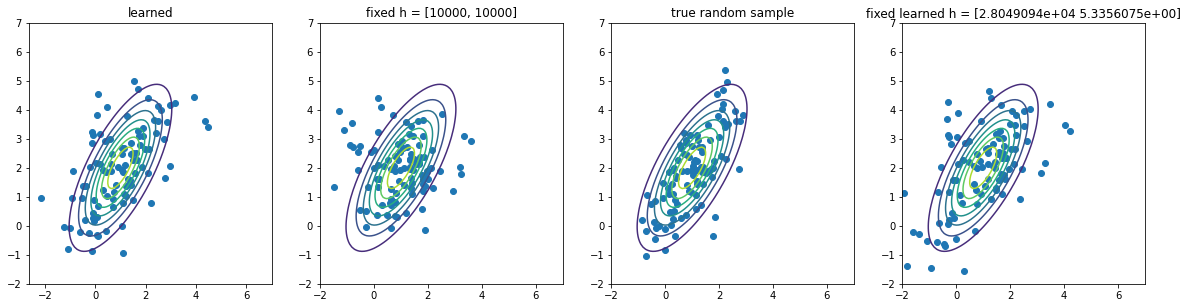

In [31]:
s = dist.sample(shape=(n,))
fig, axs = plt.subplots(1, 4, figsize = [20, 4.8])
for ax, out, title in zip(axs, (x, xs, s, xpost), ("learned", f"fixed h = {h}", "true random sample", f"fixed learned h = {learned_h}")):
    _ = ax.contour(*plot.make_meshgrid(dist.pdf, [-2, 7]))
    _ = ax.scatter(*out.T)
    _ = ax.set_title(title)

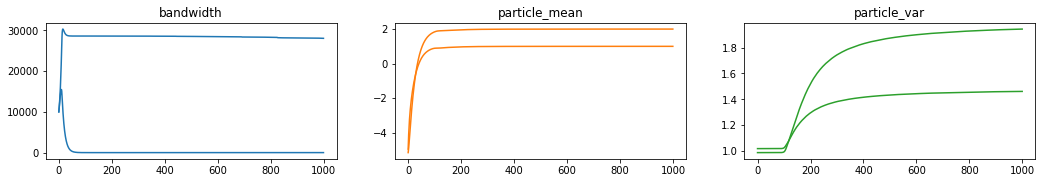

In [32]:
plot.svgd_log(log)

In [33]:
assert np.any(np.abs(x - xs) > 0.1)

# Metrics

In [34]:
s = dist.sample(shape=(n,))

In [35]:
xlearned, xfix, xsample = x, xs, s

In [36]:
mdict = [dist.compute_metrics(out) for out in (xlearned, xfix, xsample)]
mdict = utils.dict_concatenate(mdict)

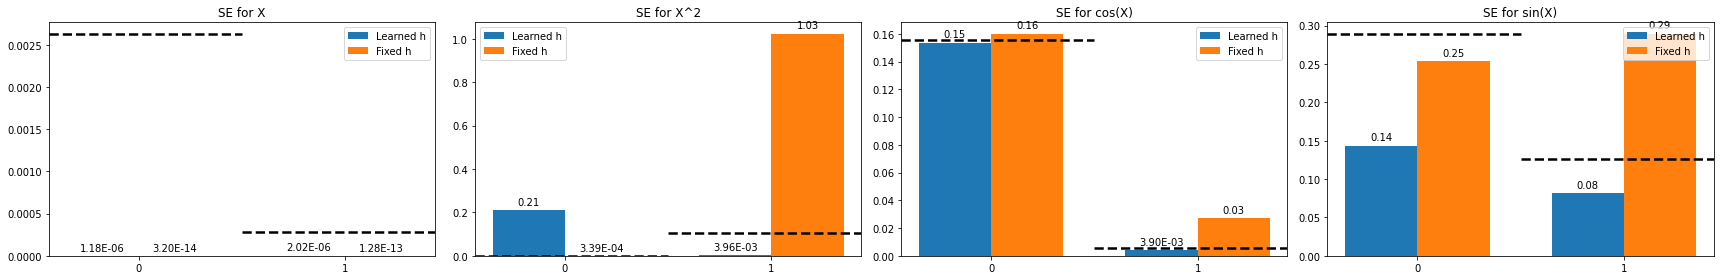

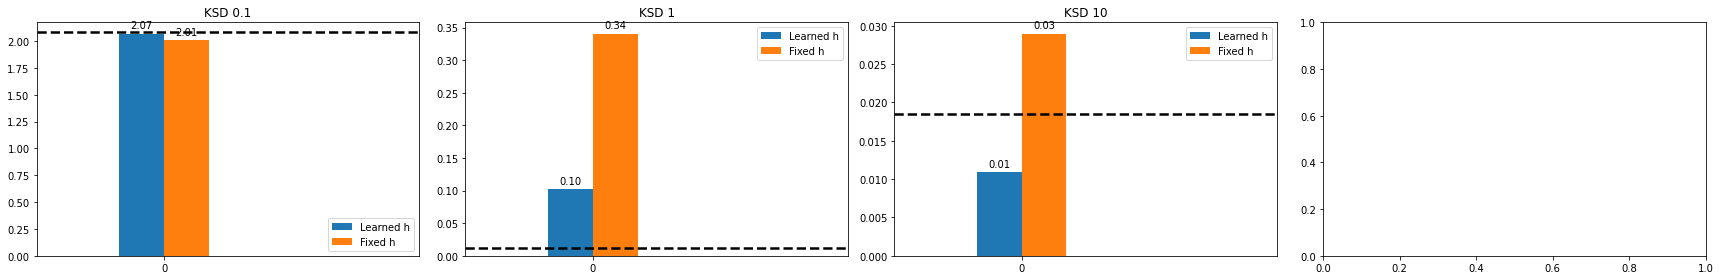

In [37]:
for key, titles in dist.metric_names.items():
    fig, axes = plt.subplots(1, 4, figsize=(2*4*3, 4))
    data = mdict[key]
    
    for ax, title, *dat in zip(axes, titles, *data):
        sample = dat[-1]
        dat = np.array(dat[:-1])

        _ = plot.make_paired_bar_chart(dat, figax=(fig, ax))
        ax.set_title(title)
        plot.set_axhlines(ax, sample)
#         ax.set_yscale("log")

In [38]:
dist.compute_metrics(xpost)

{'square_errors': DeviceArray([[0.00033233, 0.00045316],
              [0.21542987, 0.02170284],
              [0.11012641, 0.02908513],
              [0.14810419, 0.08332463]], dtype=float32),
 'ksds': DeviceArray([2.0617867 , 0.16866054, 0.01321387], dtype=float32)}

# Scatter + Contour plot

# other plots

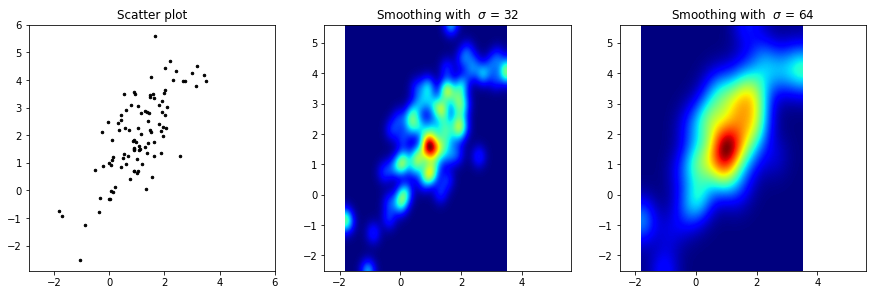

In [13]:
s = dist.sample(shape=(n,))
plot.bivariate_hist(s)

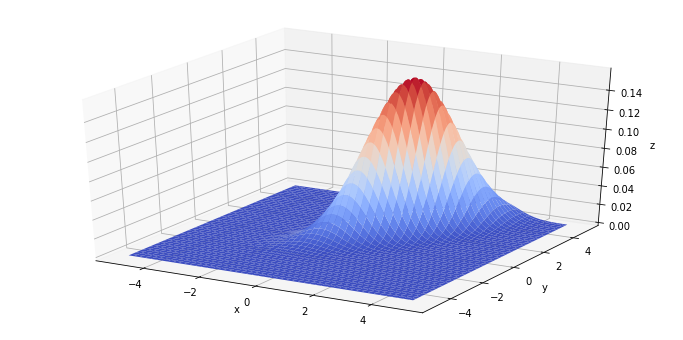

In [14]:
plot.plot_pdf(dist.pdf, [-5, 5])

# debugging

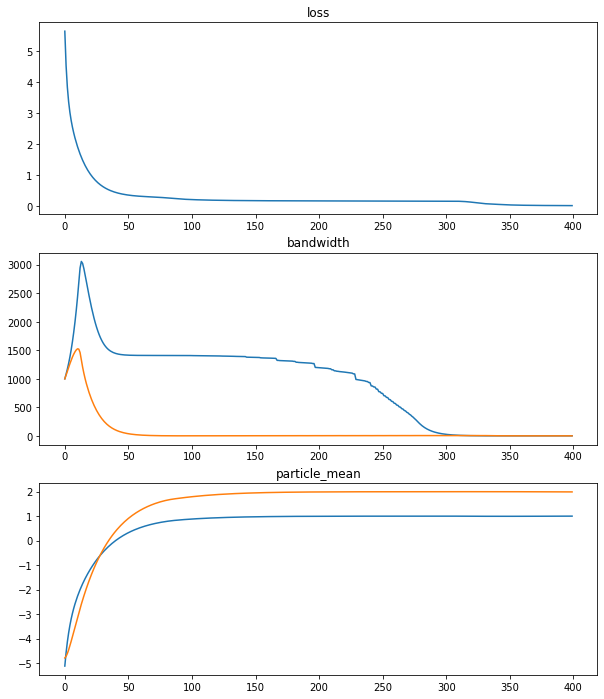

In [15]:
ind = 400
st = "-"
names = ["loss", "bandwidth", "particle_mean"]
datas = [losses] + [log["desc"][k] for k in names[1:3]]

fig, axs = plt.subplots(3, figsize=[10, 12])
for ax, name, data in zip(axs, names, datas):
    ax.plot(data[:ind], st)
    ax.set_title(name)